In [29]:
import sys
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import prettypyplot as pplt

import pyemma
import mdtraj as md

import ivac
import extq

sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [30]:
pplt.load_cmaps()
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("diverging", colors)
mpl.colormaps.register(cm_div, force=True)

/scratch/local/jobs/4058206/ipykernel_4132981/1819589819.py:20: UserWarning: Trying to register the cmap 'diverging' which already exists.
  mpl.colormaps.register(cm_div, force=True)


In [31]:
from joblib import Parallel, delayed
from multiprocess import cpu_count
n_jobs = cpu_count()

In [4]:
import MDAnalysis as mda
from MDAnalysis.analysis import rdf

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/chemfiles.py:108: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  MIN_CHEMFILES_VERSION = LooseVersion("0.9")


In [5]:
topfile = "/project/dinner/scguo/ci-vsd/models/MD-clustering-center/civsd.psf"

# $g(r)$

In [19]:
# load files
u = mda.Universe(topfile, "../../data/q_bin/q20.xtc")

/project/dinner/scguo/anaconda3/envs/py39/lib/python3.9/site-packages/MDAnalysis/coordinates/XDR.py:215: UserWarning: Reload offsets from trajectory
 ctime or size or n_atoms did not match
  warnings.warn("Reload offsets from trajectory\n "


In [23]:
t_frames = []
for i in range(2, 9):
    for j in range(10):
        t_frames.append(f"../../data/q_bin/q{i}{j}.xtc")

In [28]:
wat_sel = f"resname TIP3"
rdf_all = np.zeros((5, len(t_frames), 75))
for r, r_i in enumerate((217, 223, 226, 229, 232)):
    r_sel = f"protein and resid {r_i} and not backbone and name NE NH1 NH2"
    for i, t in enumerate(t_frames):
        u = mda.Universe(topfile, t)
        run_rdf = rdf.InterRDF(u.select_atoms(r_sel), u.select_atoms(wat_sel))
        run_rdf.run()
        rdf_all[r, i, :] = run_rdf.results.rdf

In [32]:
rdf_all.shape

(5, 70, 75)

In [33]:
avg_rdf_q = np.mean(np.reshape(rdf_all, (5, 7, 10, 75)), axis=2)

In [34]:
np.save("../../data/rdf_arg_q", avg_rdf_q)

In [35]:
avg_rdf_q.shape

(5, 7, 75)

In [38]:
importlib.reload(plotting)

<module 'plotting' from '/project/dinner/scguo/ci-vsd/notebooks/anton2/../../python/plotting.py'>

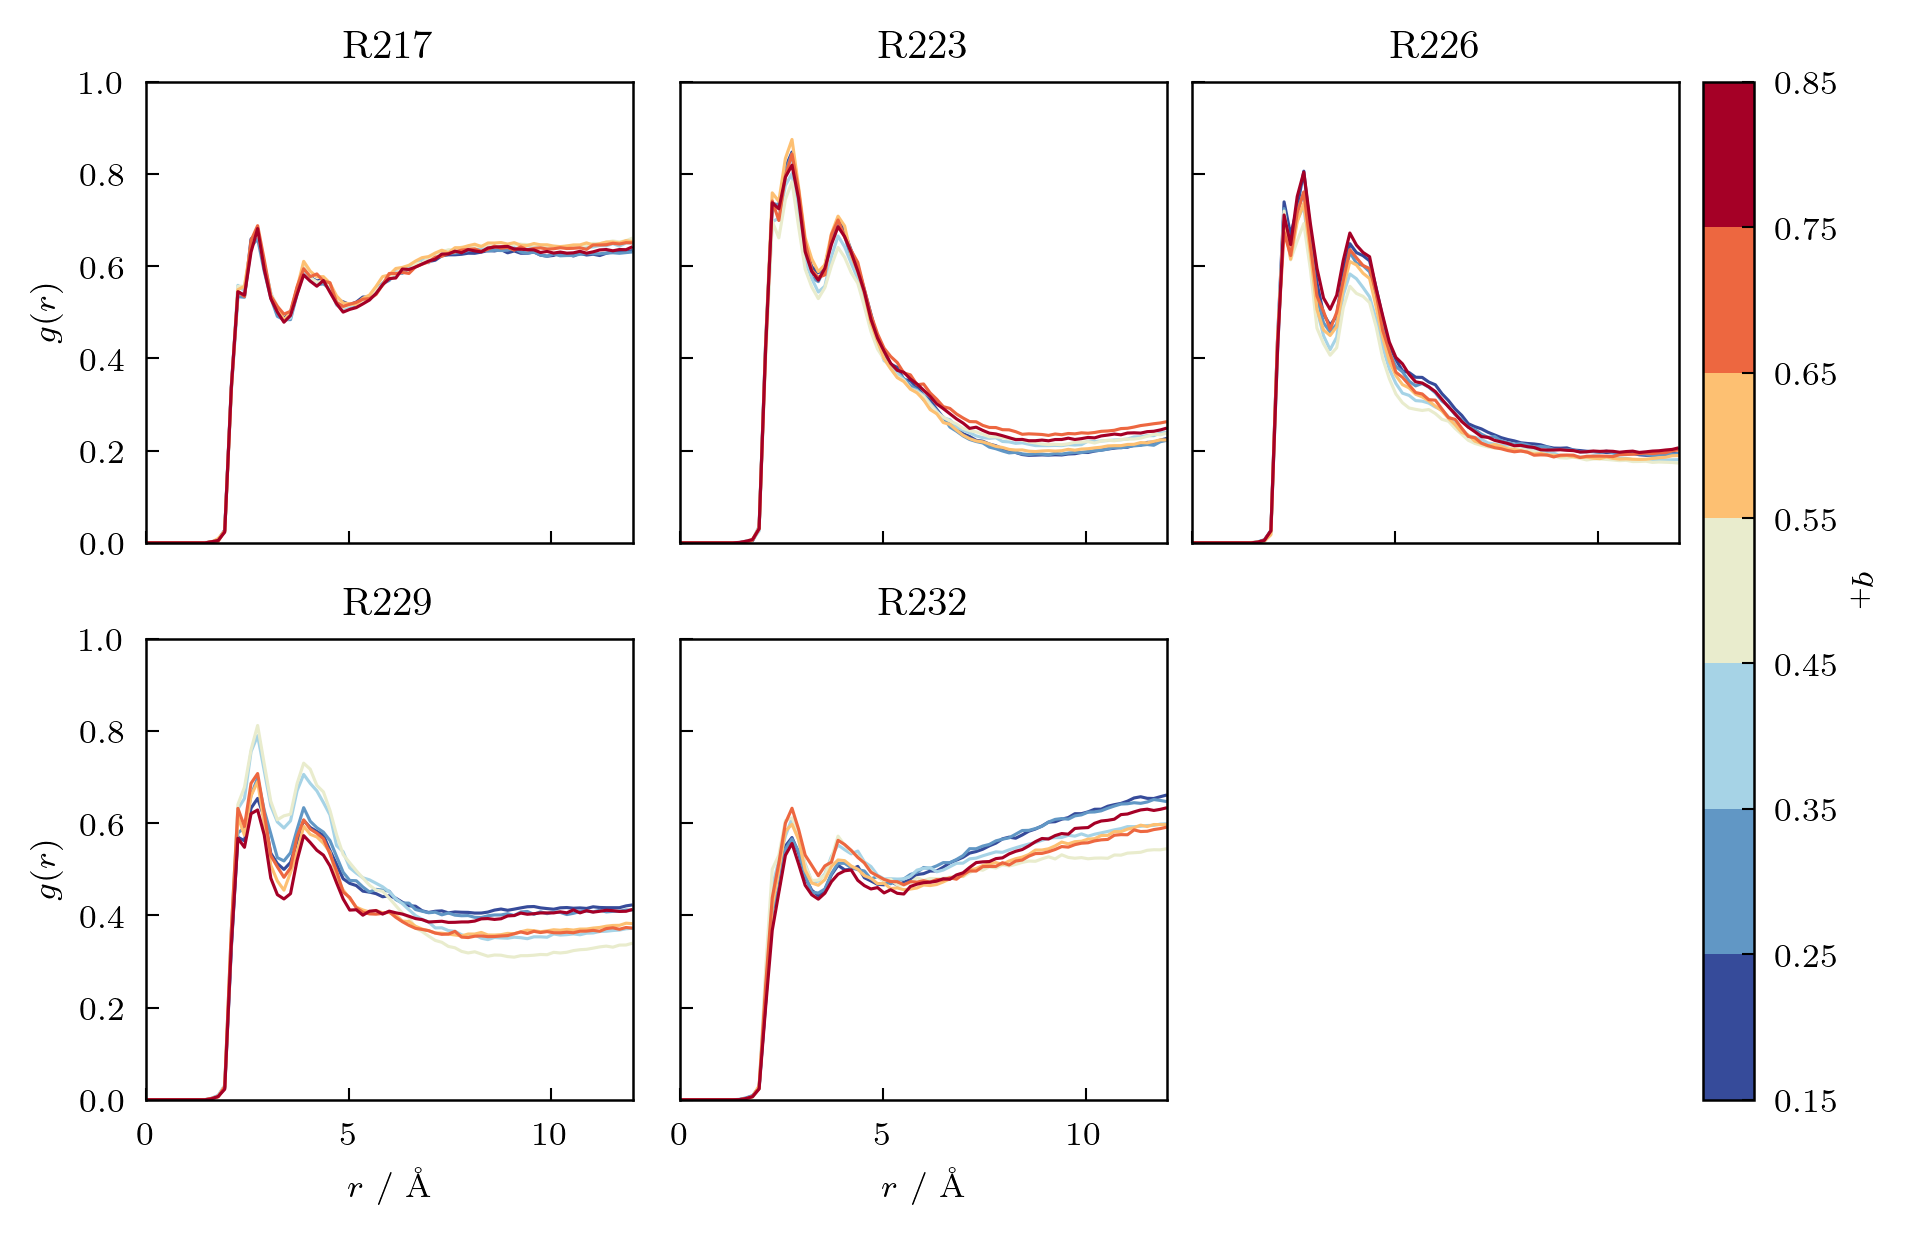

In [46]:
f, axs = plt.subplots(
    2, 3, figsize=(6.25, 4), dpi=300, sharex=True, sharey=True, constrained_layout=True)

# colors = cm_div(np.linspace(0.2, 0.8, 7))

for ax, resid, arr in zip(axs.flat, (217, 223, 226, 229, 232), avg_rdf_q):
    xs = np.tile(np.linspace(0, 12, 75)[:, None], 7).T
    lc = plotting.multiline(xs, arr, np.linspace(0.2, 0.8, 7), ax=ax, cmap=cm_div)
    
    ax.set_title(f"R{resid}")
    ax.set_xlabel("$r$ / Å")
    ax.set_ylabel("$g(r)$")
    
for ax in axs.flat:
    ax.label_outer()
    
plt.xlim([0, 12])
plt.ylim([0, 1])

bounds = np.linspace(0.15, 0.85, 8)
norm = mpl.colors.BoundaryNorm(bounds, cm_div.N)
cb = plt.colorbar(lc, ax=axs[:, -1], cmap=cm_div, norm=norm, ticks=bounds, boundaries=bounds)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
f.delaxes(axs[-1, -1])

## around whole sidechain

In [50]:
for a in u.select_atoms(f"protein and resid {r_i} and not backbone"):
    print(a)

<Atom 2043: HN of type H of resname ARG, resid 232 and segid A>
<Atom 2045: HA of type HB1 of resname ARG, resid 232 and segid A>
<Atom 2046: CB of type CT2 of resname ARG, resid 232 and segid A>
<Atom 2047: HB1 of type HA2 of resname ARG, resid 232 and segid A>
<Atom 2048: HB2 of type HA2 of resname ARG, resid 232 and segid A>
<Atom 2049: CG of type CT2 of resname ARG, resid 232 and segid A>
<Atom 2050: HG1 of type HA2 of resname ARG, resid 232 and segid A>
<Atom 2051: HG2 of type HA2 of resname ARG, resid 232 and segid A>
<Atom 2052: CD of type CT2 of resname ARG, resid 232 and segid A>
<Atom 2053: HD1 of type HA2 of resname ARG, resid 232 and segid A>
<Atom 2054: HD2 of type HA2 of resname ARG, resid 232 and segid A>
<Atom 2055: NE of type NC2 of resname ARG, resid 232 and segid A>
<Atom 2056: HE of type HC of resname ARG, resid 232 and segid A>
<Atom 2057: CZ of type C of resname ARG, resid 232 and segid A>
<Atom 2058: NH1 of type NC2 of resname ARG, resid 232 and segid A>
<Atom 20

In [51]:
wat_sel = f"resname TIP3"
rdf_all_2 = np.zeros((5, len(t_frames), 75))
for r, r_i in enumerate((217, 223, 226, 229, 232)):
    r_sel = f"protein and resid {r_i} and not backbone"
    for i, t in enumerate(t_frames):
        u = mda.Universe(topfile, t)
        run_rdf = rdf.InterRDF(u.select_atoms(r_sel), u.select_atoms(wat_sel))
        run_rdf.run()
        rdf_all_2[r, i, :] = run_rdf.results.rdf

## Just 